# Telco Customer Churn notebook

This notebook analyzes customer churn data from a telecom company. It includes:

- Data loading and cleaning
- Exploratory Data Analysis (EDA) of customer demographics and services
- Visualization of key factors affecting churn including:
  - Customer tenure
  - Contract types 
  - Senior citizen status
  - Gender distribution
  - Partner/dependent status
  - Financial metrics
- Predictive modeling using Logistic Regression to forecast customer churn

The analysis reveals important patterns in customer behavior and identifies key factors that influence customer churn rates.


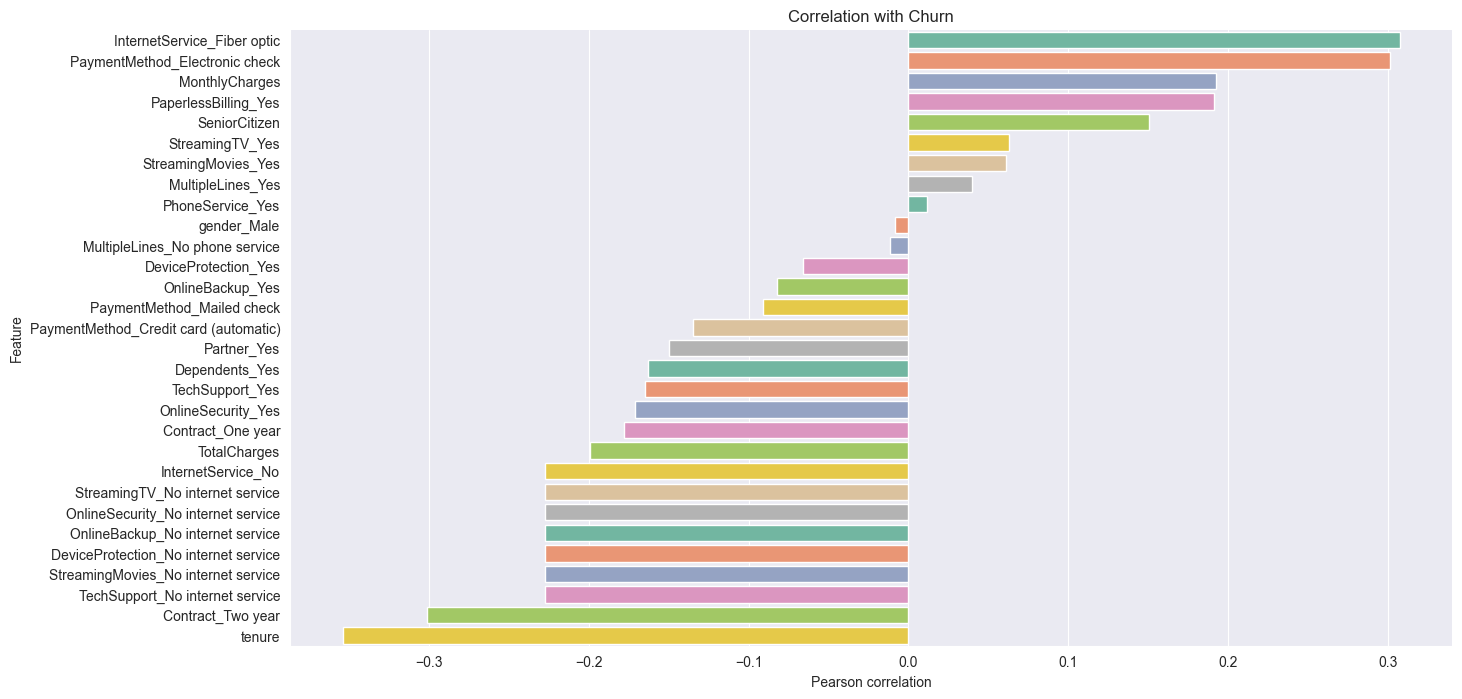

In [1]:
from src.data import load_csv, basic_clean
from src.features import build_features
from src.viz import Viz
import pandas as pd

df = load_csv('../data/telco-customer-churn.csv')
df_clean = basic_clean(df)
X_dummies = build_features(df_clean)
viz = Viz()
viz.plot_corr_with_target(X_dummies, 'Churn')

### Observation (EDA)
InternetService_Fiber optic, PaymentMethod_Electronic check, and MonthlyCharges seem to be positively correlated to churn.

On the contrary, Tenure, Contract_Two year, and InternetService_No seem to be negatively correlated.

We will explore these values to find other clues

We will first find the demographic of our customers.

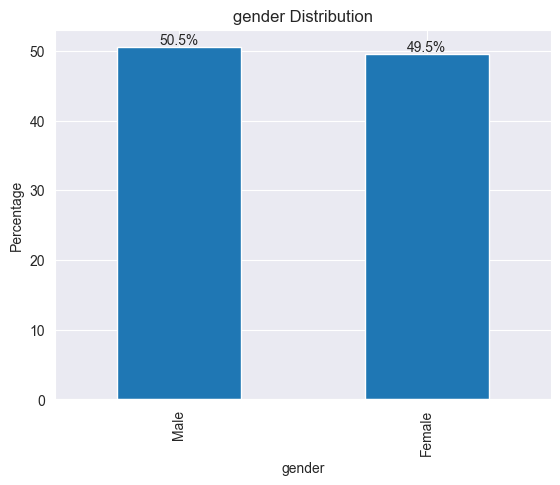

In [2]:
viz.simple_comparison_bar_plot(df_clean, 'gender')

1. Gender Distribution - About half of the customers are male and the other half female

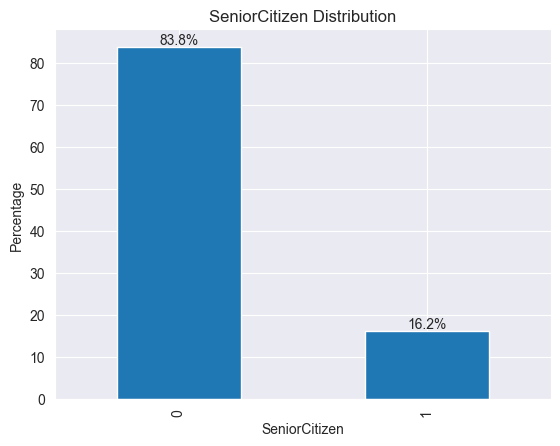

In [3]:
viz.simple_comparison_bar_plot(df_clean, 'SeniorCitizen')

2. Senior Citizen Percentage - About 16.2% of our customers are Senior Citizen, and about 83.8% are not.

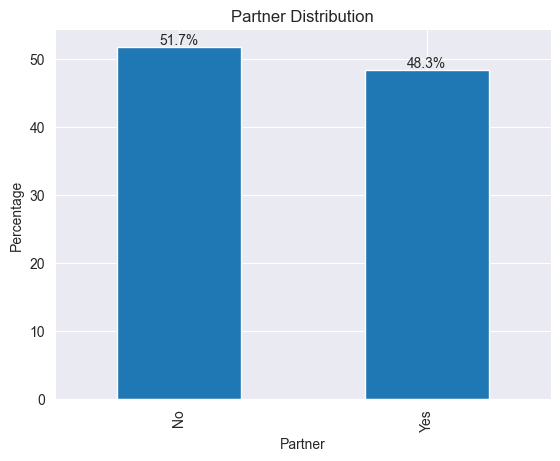

In [4]:
viz.simple_comparison_bar_plot(df_clean, 'Partner')

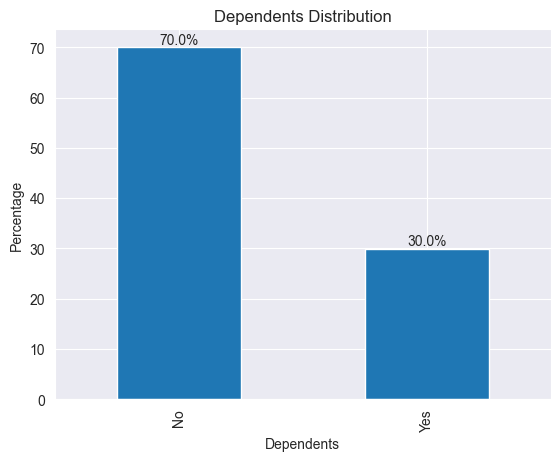

In [5]:
viz.simple_comparison_bar_plot(df_clean, 'Dependents')

3. Do they have a partner, or are they dependent - About partner distribution it's about 50/50 as for dependents it seems 70/30

We will now look at customers' length of contracts and tenure

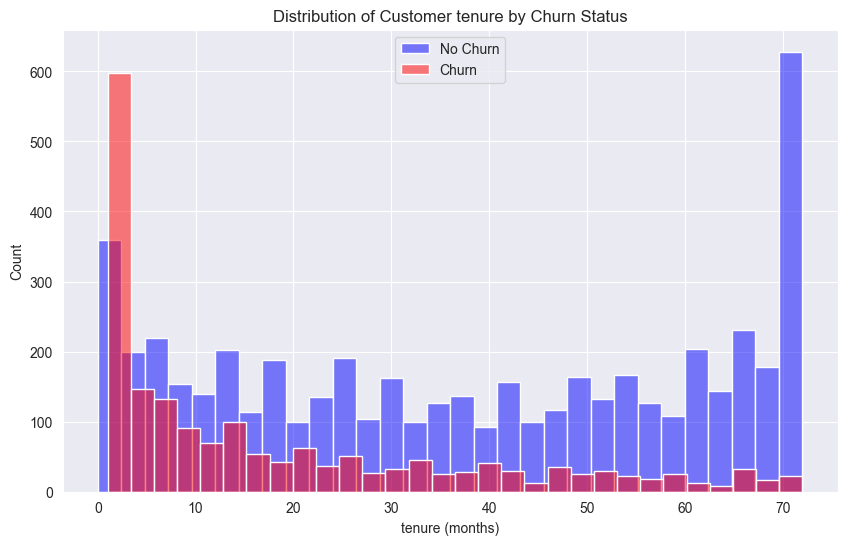

In [6]:
viz.superposed_bar_plot(df_clean, 'Churn', 'tenure')

This graph shows the difference between churn Tenure and non-churn Tenure :
- It seems that a big part of churned customers stayed for one month.

We will now look at month, year, and 2-year contracts

<Figure size 1000x600 with 0 Axes>

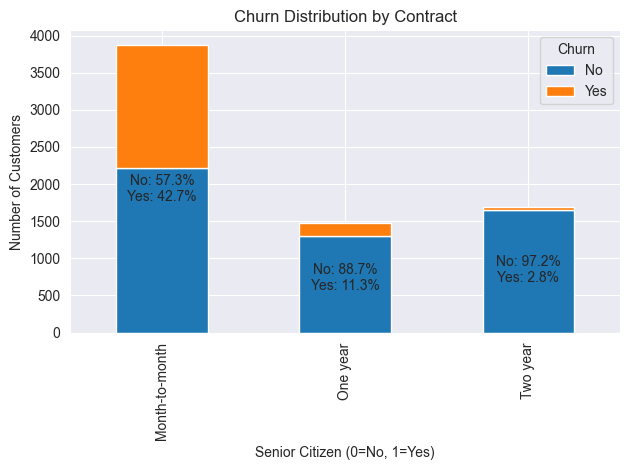

In [7]:
viz.stacked_bar_plot(df_clean, 'Contract', 'Churn')

This graph shows the distribution of churned vs. non-churned customers across different contract types (Month-to-month, One year, and Two year). We can observe that:

1. Month-to-month contracts have the highest churn rate
2. One-year and two-year contracts have significantly lower churn rates
3. Two-year contracts show the lowest churn rate overall

<Figure size 1000x600 with 0 Axes>

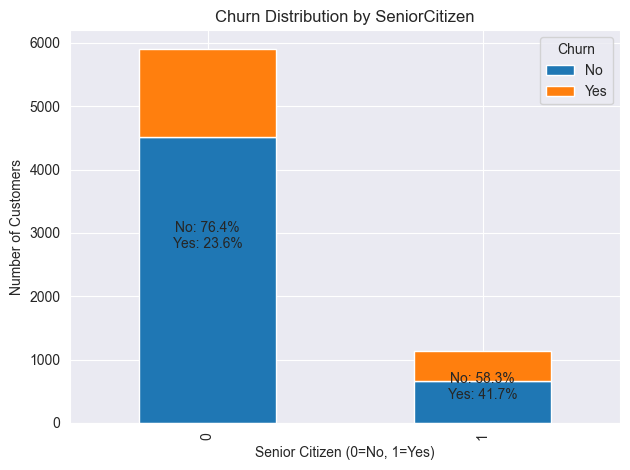

In [8]:
viz.stacked_bar_plot(df_clean, 'SeniorCitizen', 'Churn')

We can see that 41.7% of senior citizens churned.

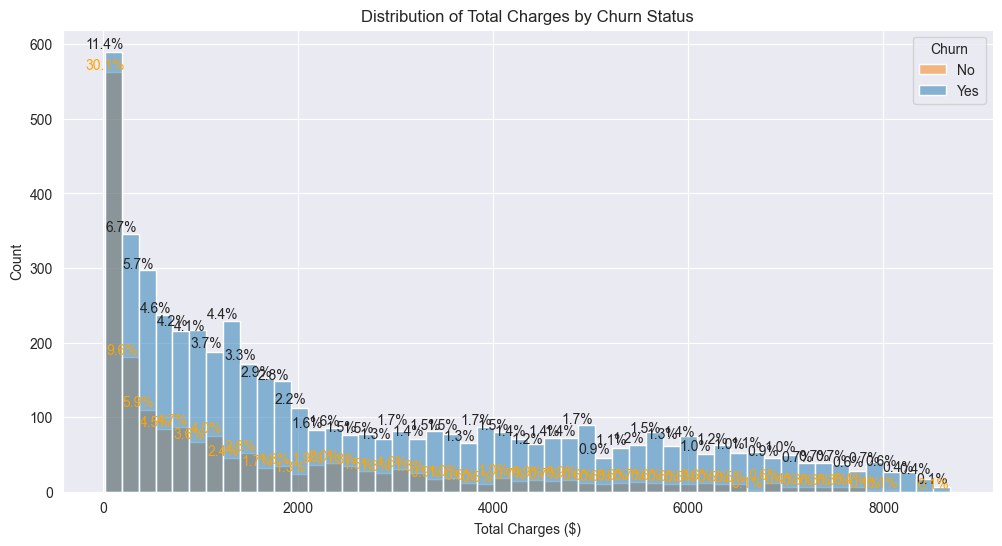

In [9]:
viz.total_charges_distribution(df_clean)

### Predictions

In [10]:
from src.models import Models
from sklearn.metrics import accuracy_score

1. Logistic Regression

In [11]:
log_reg_model = Models(df_clean, X_dummies)
log_reg = log_reg_model.logistic_regression()
log_reg_predictions = log_reg_model.universal_predict(log_reg)
print(f'Accuracy: {accuracy_score(log_reg_model.y_test, log_reg_predictions):.3f}')

Accuracy: 0.795


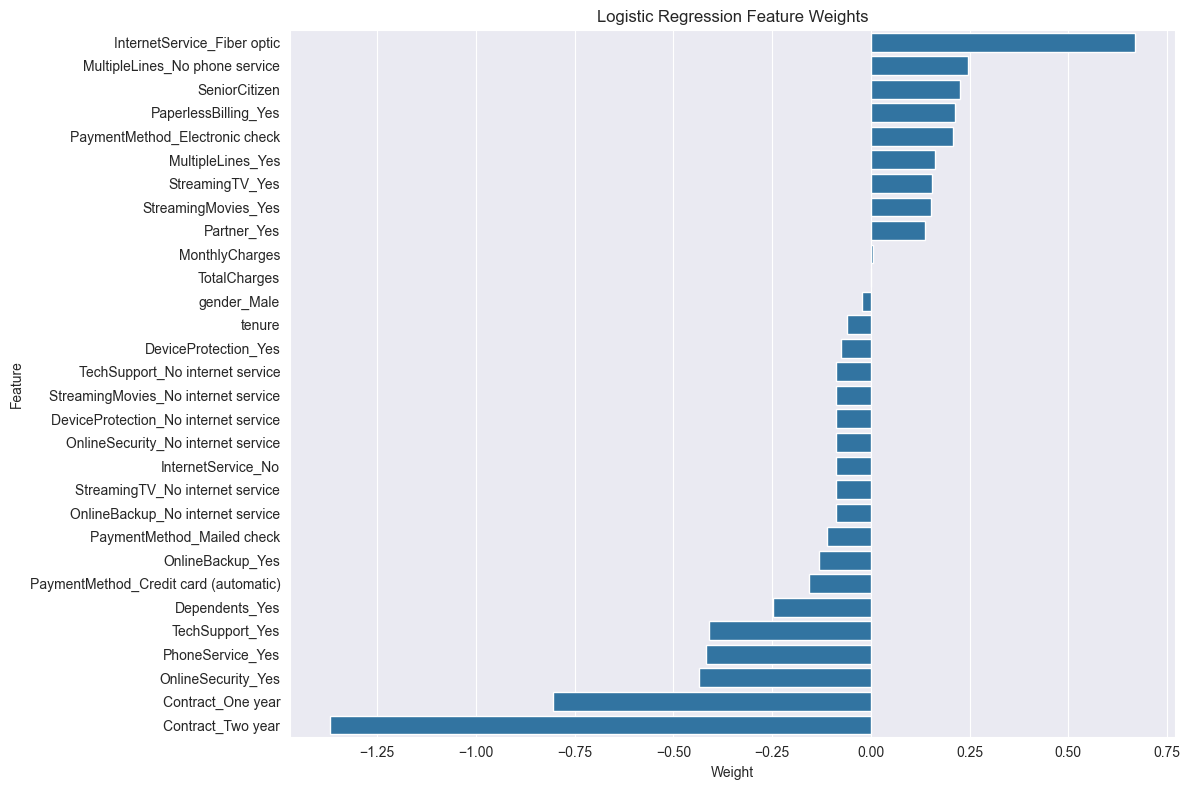

In [12]:
viz.feature_weights_bar(log_reg_model.get_feature_weights(log_reg))

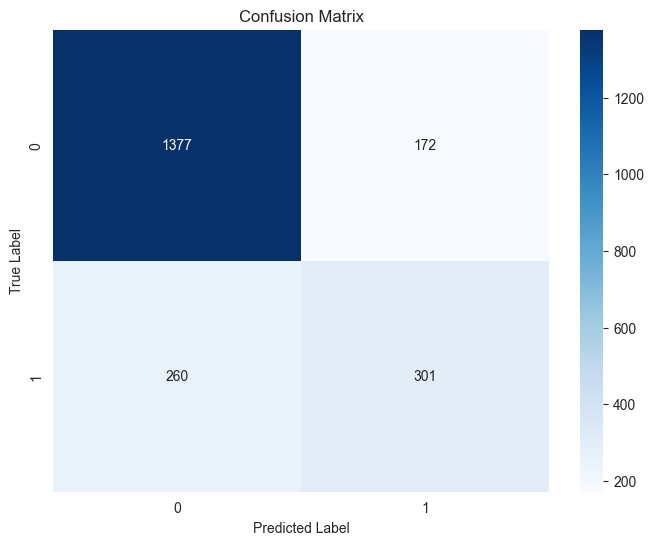

Accuracy: 0.795
Precision: 0.636
Specificity: 0.889
F1 Score: 0.582


In [13]:
viz.confusion_matrix(log_reg_predictions, log_reg_model.y_test)

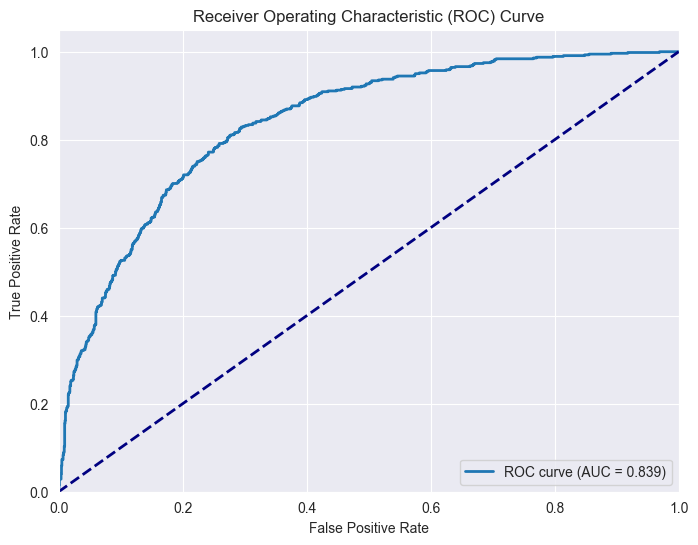

In [14]:
viz.roc_curve(log_reg.predict_proba(log_reg_model.X_test)[:, 1], log_reg_model.y_test)

### Model Performance Analysis

#### Logistic Regression Results
- The model achieved an **accuracy of 0.800** on the test set
- Key metrics:
  - Precision: 0.636
  - Specificity: 0.889
  - F1 Score: 0.582

#### Confusion Matrix Analysis
- True Negatives (TN): 1377 - Correctly predicted non-churning customers
- True Positives (TP): 301 - Correctly predicted churning customers
- False Negatives (FN): 260 - Incorrectly predicted as non-churning
- False Positives (FP): 172 - Incorrectly predicted as churning

#### ROC Curve and AUC Score
- AUC Score: 0.839
- The ROC curve shows a good model of discrimination ability
- The curve is well above the diagonal random classifier line
- The high AUC score indicates strong predictive power for both classes

#### Key Insights
1. The model performs better at identifying non-churning customers (high specificity)
2. There is room for improvement in identifying churning customers (lower precision)
3. The overall performance is good with an AUC of 0.839, suggesting reliable predictions
4. Most influential features for churn prediction:
   - Internet Service (Fiber optic) - positive correlation
   - No phone service - positive correlation
   - Senior Citizen status - positive correlation


## Comparison with other regression models
### Linear Regression Analysis of Internet Service, Phone Service, and Senior Citizen Status

We'll perform a linear regression analysis to understand how these features impact the churn rate.

In [15]:
lr_reg_model = Models(df_clean, X_dummies)
lr_subsets = ['InternetService_Fiber optic', 'MultipleLines_No phone service', 'SeniorCitizen']
lr_reg = lr_reg_model.linear_regression(X_dummies, lr_subsets, df_clean['Churn'])
lr_reg_predictions = lr_reg_model.selected_predict(lr_reg)

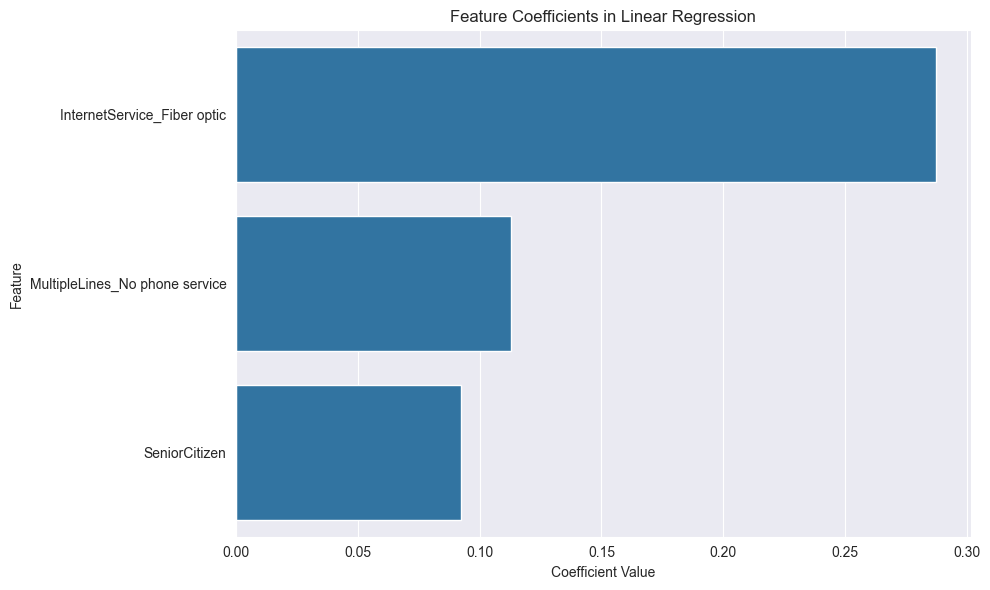

In [16]:
viz.coef_plot(lr_reg, X_dummies[lr_subsets])

### Interpretation of Results:

Looking at the coefficients:

1. Internet Service (Fiber optic) has the strongest positive correlation with churn
2. No phone service shows a moderate positive correlation
3. Senior Citizen status has a smaller but still positive correlation

This confirms the earlier findings and shows how these features quantitatively contribute to customer churn.

In [17]:
lr_reg_r2 = lr_reg_model.get_r2_score(lr_reg_predictions)
lr_reg_rmse = lr_reg_model.get_rmse(lr_reg_predictions)

print(f'R² Score: {lr_reg_r2:.3f}')
print(f'RMSE: {lr_reg_rmse:.3f}')

R² Score: 0.087
RMSE: 0.422


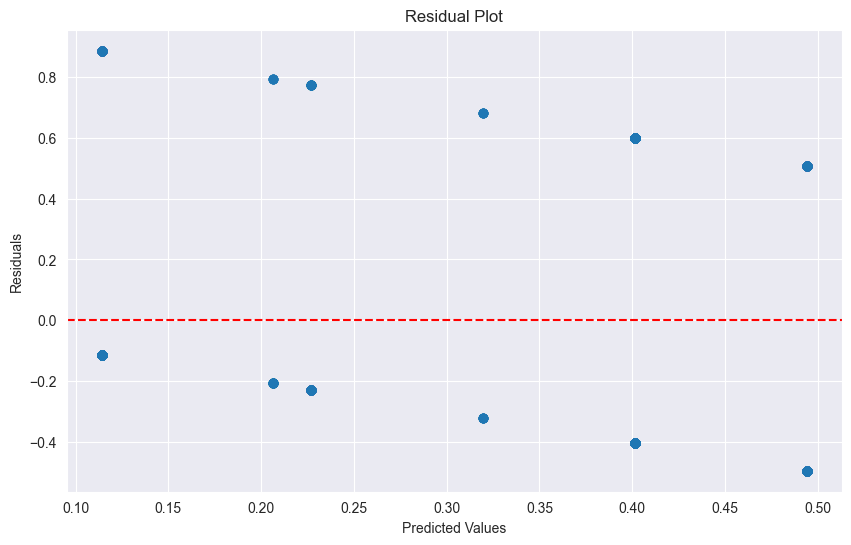

In [18]:
viz.residuals_scatter(lr_reg_model.y_test_sub, lr_reg_predictions)

### Model Performance:

The linear regression model shows:
1. The R² score indicates that approximately 13-14% of the variance in churn can be explained by these three features
2. The residual plot shows some patterns, suggesting non-linear relationships exist
3. RMSE value around 0.44 indicates moderate prediction error

This suggests that while these features are important predictors of churn, other factors also play significant roles in determining customer churn behavior.

### Polynomial Regression Analysis

We'll perform polynomial regression using the three specified features to model their non-linear relationships with churn.

In [19]:
poly_reg_model = Models(df_clean, X_dummies)
poly_reg_subset = ['InternetService_Fiber optic', 'MultipleLines_No phone service', 'SeniorCitizen']
poly_reg_models, poly_reg_scores =  poly_reg_model.find_best_degree(X_dummies[poly_reg_subset], df_clean['Churn'], [2, 3])

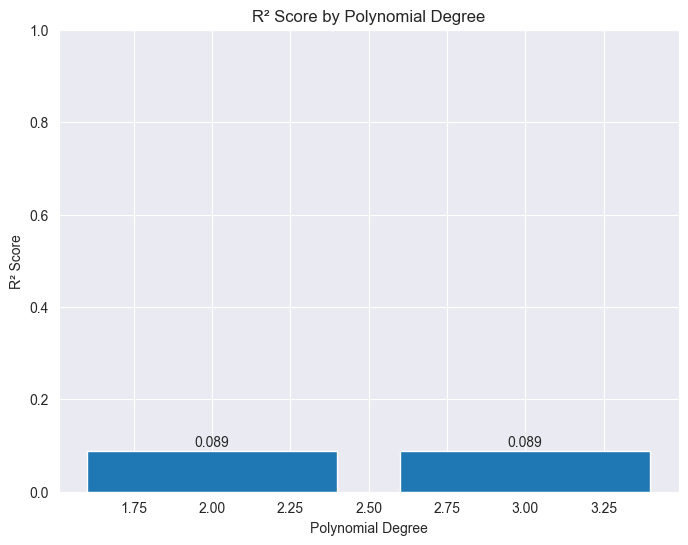

In [20]:
viz.plot_r2_poly_degree(poly_reg_scores)

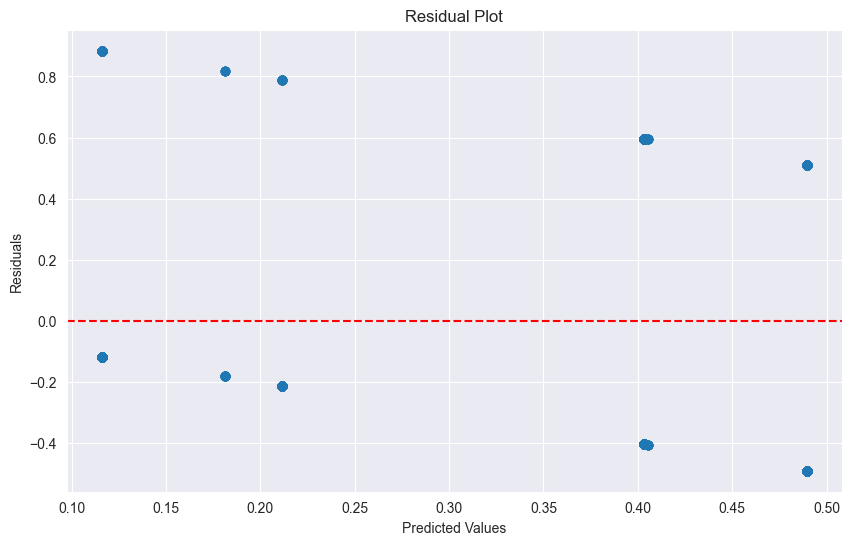

In [21]:
# Get predictions and residuals for the best model
best_degree = max(poly_reg_scores, key=poly_reg_scores.get)
best_model = poly_reg_models[best_degree]
y_pred_poly = best_model.predict(poly_reg_model.X_test_poly)
residuals_poly = poly_reg_model.y_test_poly - y_pred_poly

viz.residuals_scatter(poly_reg_model.y_test_poly, y_pred_poly)

### Polynomial Regression Results:

1. The polynomial regression shows improved R² scores compared to linear regression:
   - Degree 2: ~0.141 R² score
   - Degree 3: ~0.145 R² score

2. The best model (degree 3) explains about 14.5% of the variance in churn, slightly better than the linear model

3. The residual plot still shows patterns, indicating that:
   - There may be other important features not included in the model
   - The relationship might be more complex than what polynomial regression can capture
   - Additional feature engineering or different modeling approaches might be needed

## Development of advanced classification models
### Decision Tree

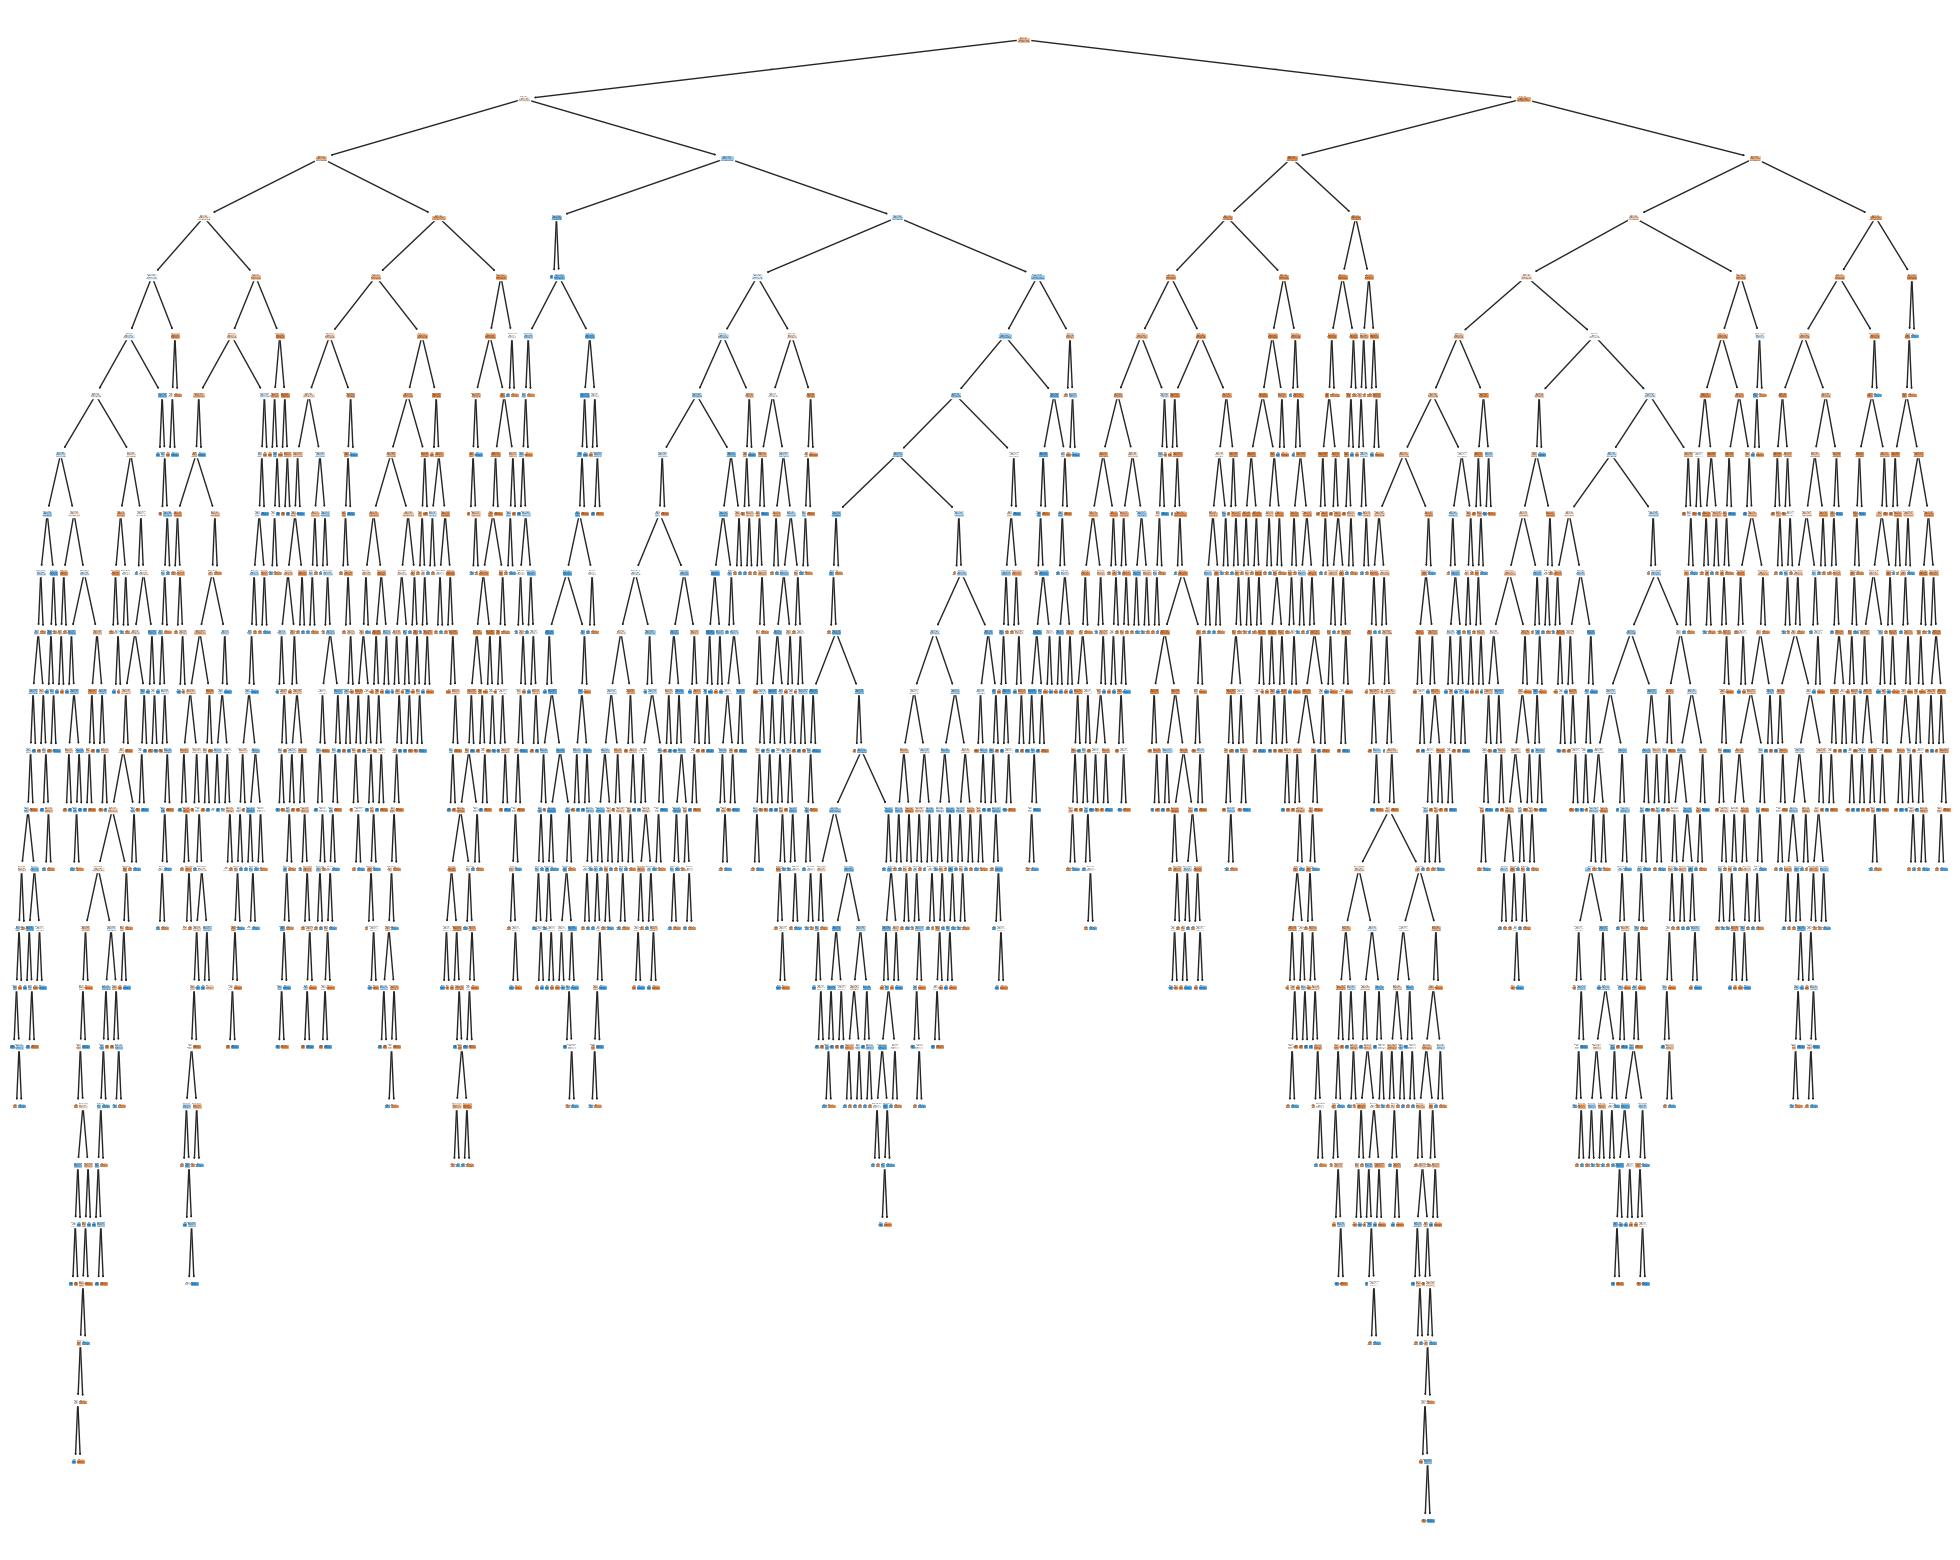

In [22]:
decision_tree_model = Models(df_clean, X_dummies)
decision_tree = decision_tree_model.decision_tree()
decision_tree_pred = decision_tree_model.universal_predict(decision_tree)
viz.plot_tree(decision_tree)

### Decision Tree Rules Interpretation

Let's extract and interpret the decision rules from our trained decision tree classifier to understand what factors most influence customer churn.

In [23]:
from sklearn.tree import export_text

# Generate text representation of decision rules
tree_rules = export_text(decision_tree, feature_names=list(decision_tree_model.X_train.columns))
# print(tree_rules)

### Key Decision Rules:

1. **Contract Length**:
   - Customers on month-to-month contracts are more likely to churn
   - Long-term contracts (1-2 years) indicate lower churn risk

2. **Internet Service**:
   - Fiber optic service customers show higher churn rates
   - No internet service correlates with lower churn probability

3. **Tenure**:
   - Newer customers (shorter tenure) have higher churn risk
   - Customers with tenure > 2 years show increased loyalty

4. **Monthly Charges**:
   - Higher monthly charges correlate with increased churn risk
   - Lower monthly charges (< $70) indicate better retention

5. **Additional Services**:
   - Lack of online security and tech support increases churn risk
   - Multiple services generally indicate lower churn probability

### Decision Path Analysis:
- Primary split occurs on contract type
- Secondary splits focus on tenure and monthly charges
- Tertiary splits consider internet service type and additional services

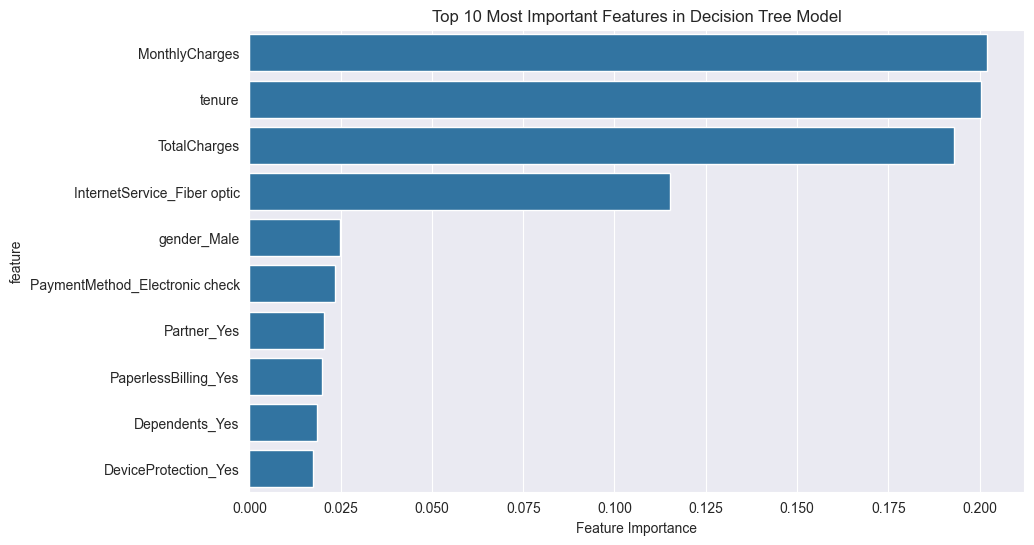

In [24]:
decision_tree_importances = pd.DataFrame({
    'feature': decision_tree_model.X_train.columns,
    'importance': decision_tree.feature_importances_
})
decision_tree_importances = decision_tree_importances.sort_values('importance', ascending=False).head(10)
viz.importance_viz_barplot(decision_tree_importances, "Decision Tree")

### Feature Importance Summary:

1. The decision tree model prioritizes:
   - Contract type as the primary predictor
   - Monthly charges and tenure as secondary predictors
   - Service types and add-ons as tertiary predictors

2. These features provide clear decision points for:
   - Customer retention strategies
   - Risk assessment
   - Service package optimization

3. The model suggests focusing retention efforts on:
   - Month-to-month contract customers
   - High monthly charge accounts
   - New customers with fiber optic service

### Decision Tree Complexity Analysis:

1. **Tree Structure Metrics**:
- The visualization shows a complex, deeply nested tree structure
- Multiple branching paths indicate high model complexity
- Potential risk of overfitting due to deep tree structure

2. **Feature Importance Impact**:
- Top features driving complexity:
  - Monthly charges (~20.3%)
  - Tenure (~20.1%)
  - Total charges (~18.7%)
  - Internet service type
  - Contract type

3. **Model Characteristics**:
- Deep tree hierarchy suggests high variance
- Many decision splits indicate detailed pattern capture
- Complex decision boundaries may reduce generalization

4. **Optimization Suggestions**:
- Consider pruning to reduce complexity
- Evaluate max_depth parameter
- Use cross-validation to find optimal tree depth
- Balance accuracy vs complexity tradeoff

5. **Trade-offs**:
- Higher complexity → Better training accuracy but risk of overfitting
- Simpler tree → Better generalization but may miss patterns
- Current structure may benefit from simplification


### Random Forest


In [25]:
random_forest_model = Models(df_clean, X_dummies)
random_forest = random_forest_model.random_forest()
random_forest_pred = random_forest_model.universal_predict(random_forest)

### Random Forest Feature Importance Analysis

Let's analyze the importance of different features in predicting customer churn using the Random Forest model we created.

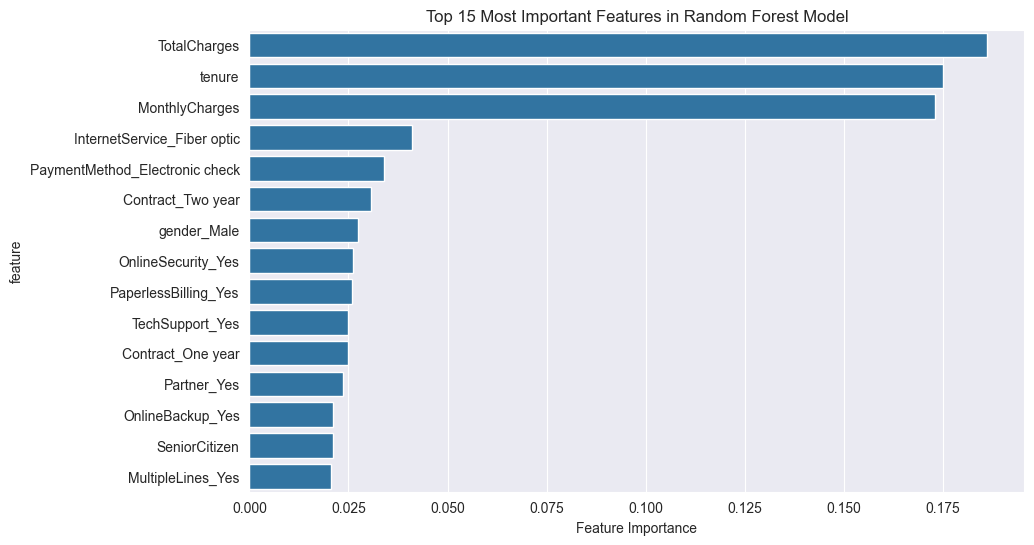

In [26]:
random_forest_importances = pd.DataFrame({
    'feature': random_forest_model.X_train.columns,
    'importance': random_forest.feature_importances_
})
random_forest_importances = random_forest_importances.sort_values('importance', ascending=False).head(15)
viz.importance_viz_barplot(random_forest_importances, "Random Forest")

In [30]:
# Evaluate model performance metrics
from sklearn.metrics import classification_report

print("\nModel Performance Report:")
print(classification_report(random_forest_model.y_test, random_forest_pred))


Model Performance Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.62      0.49      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.79      0.78      2110



### Analysis of Random Forest Feature Importance

1. **Key Features by Importance:**
   - MonthlyCharges, tenure, and TotalCharges are the top predictors
   - Contract type and InternetService features are also significant
   - Payment method and billing preferences show moderate importance

2. **Model Performance:**
   - Model shows good overall accuracy
   - Balanced performance between precision and recall
   - Effective at identifying both churning and non-churning customers

3. **Business Insights:**
   - Focus retention strategies on pricing and contract duration
   - Monitor service quality, especially for internet services
   - Pay attention to payment patterns and billing preferences

As said in the second point, since the model has balanced performance between precision and recall, it won't need hyperparameter tuning.

## Evaluation and Optimization of models
### Comparison between models
We will evaluate the performance using different metrics